In [1]:
import psycopg2
import xml.etree.ElementTree as ET

# Define your PostgreSQL connection parameters
db_params = {
    "dbname": "NewDB",
    "user": "postgres",
    "password": "123",
    "host": "localhost"
}

# Connect to your PostgreSQL database
conn = psycopg2.connect(**db_params)
cursor = conn.cursor()

# Create a table to store the data
cursor.execute("""
    CREATE TABLE IF NOT EXISTS nysk_dataset (
        docid INTEGER PRIMARY KEY,
        source TEXT,
        url TEXT,
        title TEXT,
        summary TEXT,
        text TEXT,
        date TIMESTAMP
    );
""")
conn.commit()



In [2]:
def saveData(document):
    
    docid = document["docid"]
    source = document["source"]
    url = document["url"]
    title = document["title"]
    summary = document["summary"]
    text = document["text"]
    date = document["date"]


    cursor.execute("""
    INSERT INTO nysk_dataset (docid, source, url, title, summary, text, date)
    VALUES (%s, %s, %s, %s, %s, %s, %s)
    ON CONFLICT (docid) DO NOTHING;
    """, (docid, source, url, title, summary, text, date))
    
    conn.commit()

In [3]:
from pymongo import MongoClient

# Connect to MongoDB
client = MongoClient('mongodb://localhost:27017/')
db = client['DBproject']
collection = db['dataset2']

# Retrieve all documents from the collection
documents = collection.find()

# Process each document
for document in documents:

    saveData(document)

print("All documents processed.")



cursor.close()
conn.close()


All documents processed.


In [4]:
import psycopg2
import pandas as pd

# Define your PostgreSQL connection parameters
db_params = {
    "dbname": "NewDB",
    "user": "postgres",
    "password": "123",
    "host": "localhost"
}

# Connect to your PostgreSQL database
conn = psycopg2.connect(**db_params)
cursor = conn.cursor()

# Fetch data from PostgreSQL
cursor.execute("SELECT * FROM nysk_dataset")
data = cursor.fetchall()
columns = [desc[0] for desc in cursor.description]
df = pd.DataFrame(data, columns=columns)

# Display all attributes and first 5 rows of the dataset
print("All Attributes:")
print(df.columns)

print("\nFirst 5 Rows of the Dataset:")
print(df.head())

cursor.close()
conn.close()


All Attributes:
Index(['docid', 'source', 'url', 'title', 'summary', 'text', 'date'], dtype='object')

First 5 Rows of the Dataset:
   docid                     source  \
0      0     www.huffingtonpost.com   
1      1         www.gulf-times.com   
2      2          www.frumforum.com   
3      3  www.buenosairesherald.com   
4      4      www.thedailybeast.com   

                                                 url  \
0  http://www.huffingtonpost.com/2011/05/18/domin...   
1  http://www.gulf-times.com/site/topics/article....   
2  http://www.frumforum.com/why-is-france-falling...   
3  http://www.buenosairesherald.com/article/67983...   
4  http://www.thedailybeast.com/cheat-sheet/item/...   

                                               title  \
0  Dominique Strauss-Kahn Sex-Crime Case: Accuser...   
1       Strauss-Kahn’s NY apartment plan falls apart   
2  Why is France Falling for <em>Strauss-Kahn</em...   
3  Traces of Strauss-Kahn's DNA found on alleged ...   
4        Dominiq

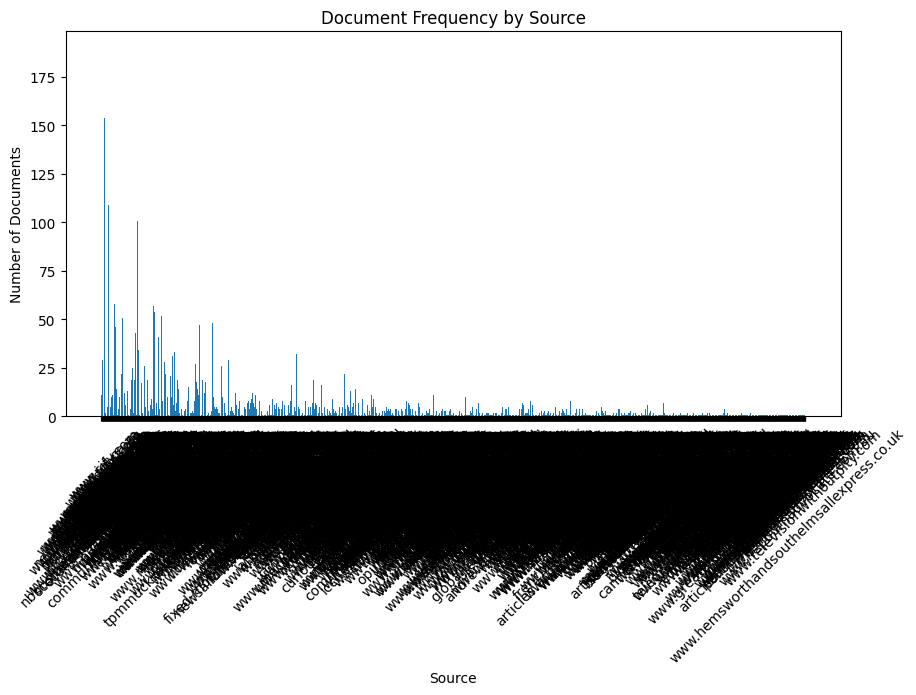

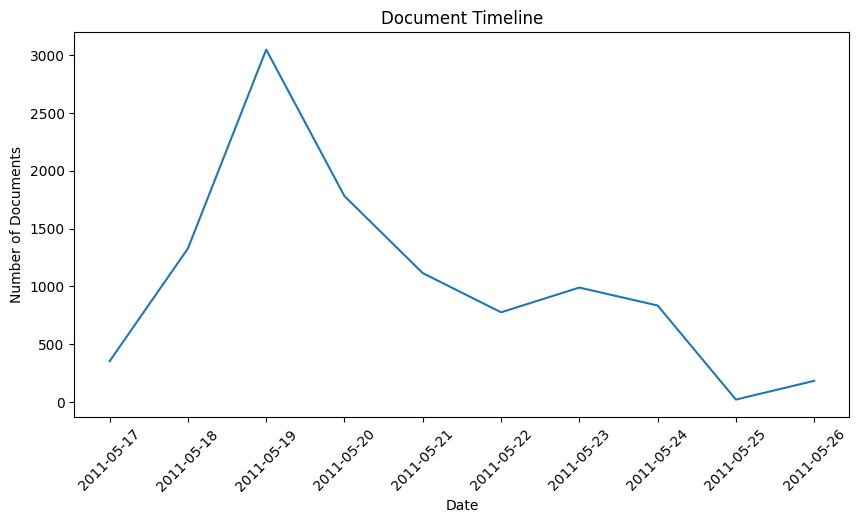

In [5]:
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt
from collections import Counter
import datetime

# Parse the XML file
tree = ET.parse('nysk.xml')
root = tree.getroot()

# Initialize data structures
sources = []
dates = []

# Iterate through each document
for document in root.findall('.//document'):
    source = document.find('source').text
    date_text = document.find('date').text
    date = datetime.datetime.strptime(date_text, "%Y-%m-%d %H:%M:%S")

    sources.append(source)
    dates.append(date.date())

# Plotting

# 1. Frequency of Documents by Source
source_counts = Counter(sources)
plt.figure(figsize=(10, 5))
plt.bar(source_counts.keys(), source_counts.values())
plt.xlabel('Source')
plt.ylabel('Number of Documents')
plt.title('Document Frequency by Source')
plt.xticks(rotation=45)
plt.show()

# 2. Timeline of Documents
date_counts = Counter(dates)
dates_sorted = sorted(date_counts.items())
plt.figure(figsize=(10, 5))
plt.plot([date for date, _ in dates_sorted], [count for _, count in dates_sorted])
plt.xlabel('Date')
plt.ylabel('Number of Documents')
plt.title('Document Timeline')
plt.xticks(rotation=45)
plt.show()

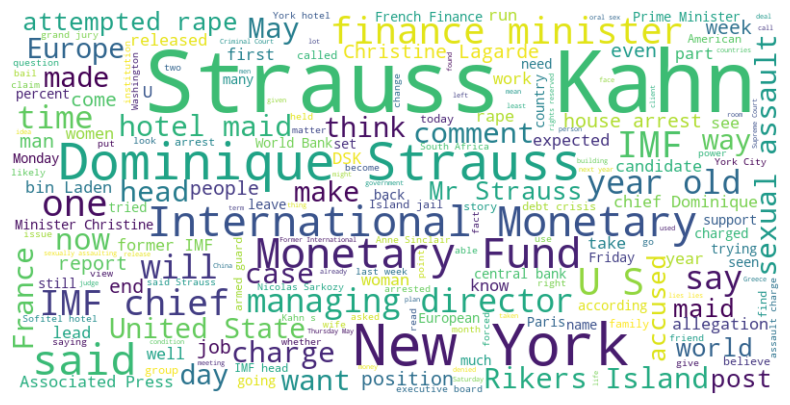

In [6]:
import xml.etree.ElementTree as ET
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Parse the XML file
tree = ET.parse('nysk.xml')
root = tree.getroot()

# Collect all text into a single string
all_text = ""
for document in root.findall('.//document'):
    text = document.find('text').text
    if text:
        all_text += text + " "

# Generate a word cloud image
wordcloud = WordCloud(width = 800, height = 400, background_color ='white').generate(all_text)

# Display the generated image
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

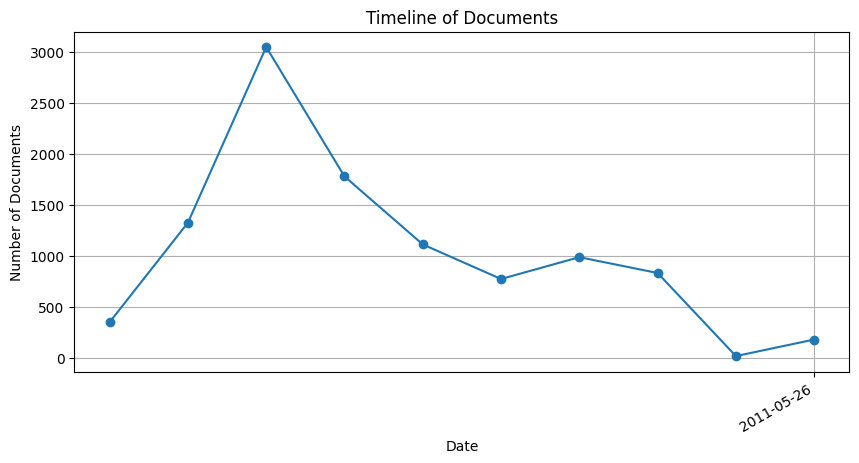

In [7]:
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from collections import Counter
import datetime

# Parse the XML file
tree = ET.parse('nysk.xml')
root = tree.getroot()

# Initialize a list to store dates
dates = []

# Iterate through each document and extract the date
for document in root.findall('.//document'):
    date_text = document.find('date').text
    date = datetime.datetime.strptime(date_text, "%Y-%m-%d %H:%M:%S")
    dates.append(date.date())  # Store only the date part

# Count the number of documents for each date
date_counts = Counter(dates)

# Sort dates for plotting
dates_sorted, counts_sorted = zip(*sorted(date_counts.items()))

# Create the plot
plt.figure(figsize=(10, 5))
plt.plot(dates_sorted, counts_sorted, marker='o')

# Formatting the plot
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=10))  # Adjust interval as needed
plt.gcf().autofmt_xdate()  # Auto-format the dates for better readability
plt.xlabel('Date')
plt.ylabel('Number of Documents')
plt.title('Timeline of Documents')
plt.grid(True)
plt.show()

In [8]:
import csv
from pymongo import MongoClient

# Connect to MongoDB
client = MongoClient('mongodb://localhost:27017/')
db = client['DBproject2']
collection = db['dataset']

# Open and read the CSV file
with open('news_summary.csv', mode='r') as csvfile:
    csv_reader = csv.DictReader(csvfile)

    # Iterate through each row in the CSV
    for row in csv_reader:
        # Each row is a dictionary representing a document
        # You might need to adjust the field names based on your CSV file structure

        # Insert data into MongoDB
        collection.insert_one(row)

print("CSV data inserted into MongoDB successfully.")

CSV data inserted into MongoDB successfully.


In [9]:
import psycopg2
import xml.etree.ElementTree as ET

# Define your PostgreSQL connection parameters
db_params = {
    "dbname": "NewDB",
    "user": "postgres",
    "password": "123",
    "host": "localhost"
}

# Connect to your PostgreSQL database
conn = psycopg2.connect(**db_params)
cursor = conn.cursor()

# Create a table to store the data
cursor.execute("""
    CREATE TABLE IF NOT EXISTS new_dataset (
        author TEXT,
        date TEXT,
        headlines TEXT,
        read_more TEXT,
        textt TEXT,
        ctext TEXT
    );
""")
conn.commit()


In [10]:
def saveData(document):
    
    author = document["author"]
    date = document["date"]
    headlines = document["headlines"]
    read_more = document["read_more"]
    textt = document["text"]
    ctext = document["ctext"]


    cursor.execute("""
    INSERT INTO new_dataset (author, date, headlines, read_more, textt, ctext)
    VALUES (%s, %s, %s, %s, %s, %s);
    """, (author, date, headlines, read_more, textt, ctext))
    
    conn.commit()

In [11]:
from pymongo import MongoClient

# Connect to MongoDB
client = MongoClient('mongodb://localhost:27017/')
db = client['DBproject2']
collection = db['dataset']

# Retrieve all documents from the collection
documents = collection.find()

# Process each document
for document in documents:

    saveData(document)

print("All documents processed.")



cursor.close()
conn.close()

All documents processed.


In [12]:
import psycopg2
import pandas as pd

# Define your PostgreSQL connection parameters
db_params = {
    "dbname": "NewDB",
    "user": "postgres",
    "password": "123",
    "host": "localhost"
}

# Connect to your PostgreSQL database
conn = psycopg2.connect(**db_params)
cursor = conn.cursor()

def fetchData():
    # Fetch data from PostgreSQL
    cursor.execute("SELECT * FROM new_dataset")
    data = cursor.fetchall()
    columns = [desc[0] for desc in cursor.description]
    df = pd.DataFrame(data, columns=columns)
    return df

# Fetch and display all attributes
all_attributes = cursor.execute("SELECT column_name FROM information_schema.columns WHERE table_name = 'new_dataset';")
attributes = cursor.fetchall()
attributes = [attr[0] for attr in attributes]
print("All attributes:", attributes)

# Display the first 5 rows of the dataset
df = fetchData()
print("\nFirst 5 rows of the dataset:")
print(df.head())

cursor.close()
conn.close()


All attributes: ['author', 'date', 'headlines', 'read_more', 'textt', 'ctext']

First 5 rows of the dataset:
               author                  date  \
0        Chhavi Tyagi  03 Aug 2017,Thursday   
1         Daisy Mowke  03 Aug 2017,Thursday   
2      Arshiya Chopra  03 Aug 2017,Thursday   
3       Sumedha Sehra  03 Aug 2017,Thursday   
4  Aarushi Maheshwari  03 Aug 2017,Thursday   

                                           headlines  \
0  Daman & Diu revokes mandatory Rakshabandhan in...   
1  Malaika slams user who trolled her for 'divorc...   
2  'Virgin' now corrected to 'Unmarried' in IGIMS...   
3  Aaj aapne pakad liya: LeT man Dujana before be...   
4  Hotel staff to get training to spot signs of s...   

                                           read_more  \
0  http://www.hindustantimes.com/india-news/raksh...   
1  http://www.hindustantimes.com/bollywood/malaik...   
2  http://www.hindustantimes.com/patna/bihar-igim...   
3  http://indiatoday.intoday.in/story/abu-dujan

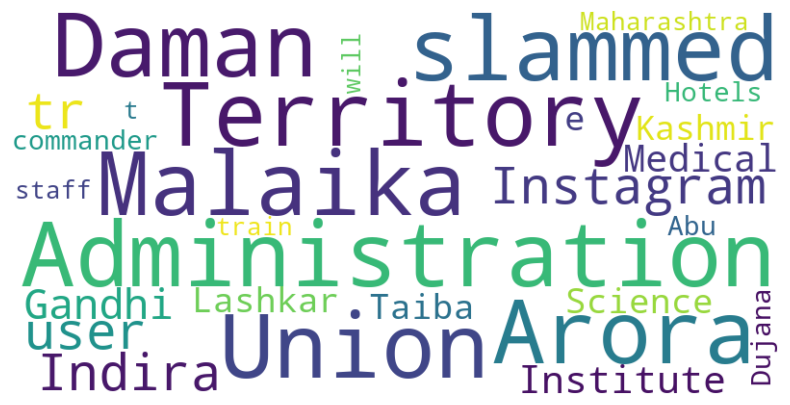

In [26]:
from wordcloud import WordCloud

all_text = ' '.join(df['textt'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()


In [20]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the CSV file into a Pandas DataFrame
df = pd.read_csv('news_summary.csv')

# Visualization 1: Bar chart for the number of articles by author
plt.figure(figsize=(12, 6))
sns.countplot(x='author', data=df, order=df['author'].value_counts().index)
plt.xticks(rotation=90)
plt.title('Number of Articles by Author')
plt.xlabel('Author')
plt.ylabel('Number of Articles')
plt.show()

# Visualization 2: Word cloud for headlines
from wordcloud import WordCloud

all_headlines = " ".join(df['headlines'].dropna())
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_headlines)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title('Word Cloud for Headlines')
plt.show()

# Visualization 3: Histogram for the length of headlines
df['headline_length'] = df['headlines'].apply(len)
plt.figure(figsize=(10, 5))
plt.hist(df['headline_length'], bins=30, edgecolor='black')
plt.title('Distribution of Headline Length')
plt.xlabel('Headline Length')
plt.ylabel('Frequency')
plt.show()


UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe2 in position 29445: invalid continuation byte

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the CSV file into a Pandas DataFrame with a different encoding
df = pd.read_csv('news_summary.csv', encoding='ISO-8859-1')

# Continue with your visualization code


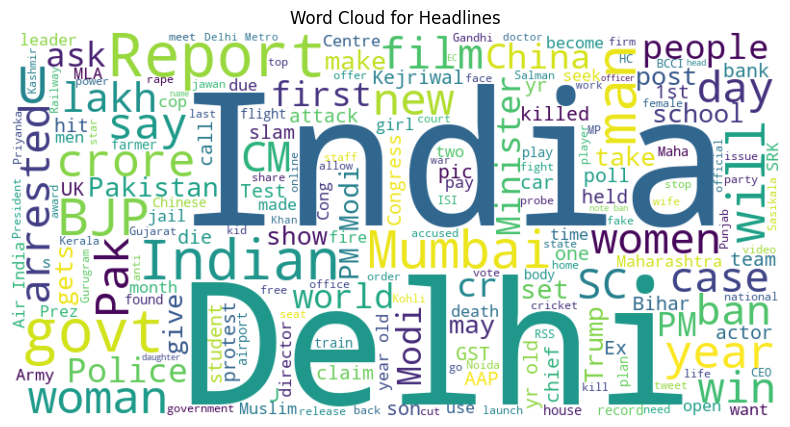

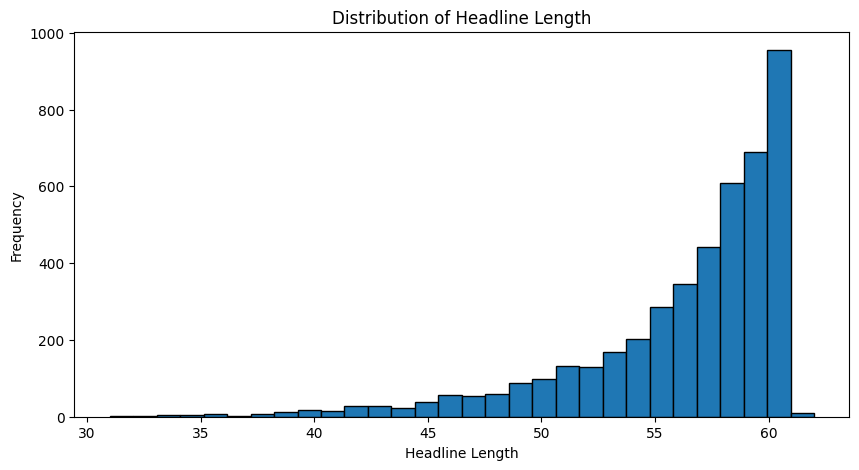

In [23]:
from wordcloud import WordCloud

all_headlines = " ".join(df['headlines'].dropna())
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_headlines)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title('Word Cloud for Headlines')
plt.show()

# Visualization 3: Histogram for the length of headlines
df['headline_length'] = df['headlines'].apply(len)
plt.figure(figsize=(10, 5))
plt.hist(df['headline_length'], bins=30, edgecolor='black')
plt.title('Distribution of Headline Length')
plt.xlabel('Headline Length')
plt.ylabel('Frequency')
plt.show()


In [31]:
import pandas as pd

# Load the CSV file into a Pandas DataFrame with a different encoding
df = pd.read_csv('news_summary.csv', encoding='ISO-8859-1')

# Display the column names in the DataFrame
print("Column names:", df.columns)


Column names: Index(['author', 'date', 'headlines', 'read_more', 'text', 'ctext'], dtype='object')


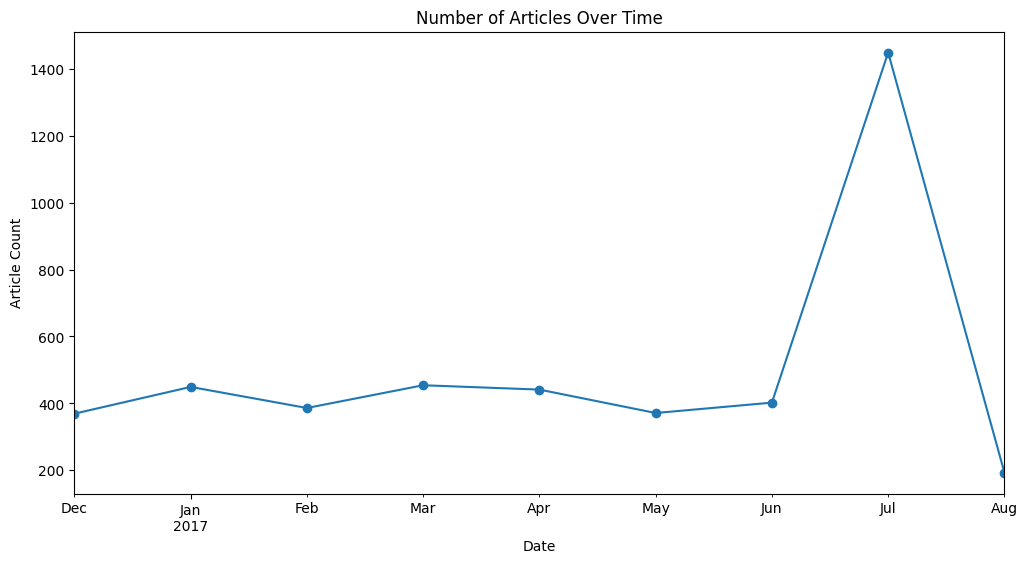

In [32]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the dataset
df = pd.read_csv('news_summary.csv', encoding='ISO-8859-1')

# Convert 'date' to datetime format
df['date'] = pd.to_datetime(df['date'], errors='coerce')

# Set 'date' as the index
df.set_index('date', inplace=True)

# Resample the data by month and plot the time series
plt.figure(figsize=(12, 6))
df.resample('M').size().plot(legend=False, marker='o')
plt.title('Number of Articles Over Time')
plt.xlabel('Date')
plt.ylabel('Article Count')
plt.show()

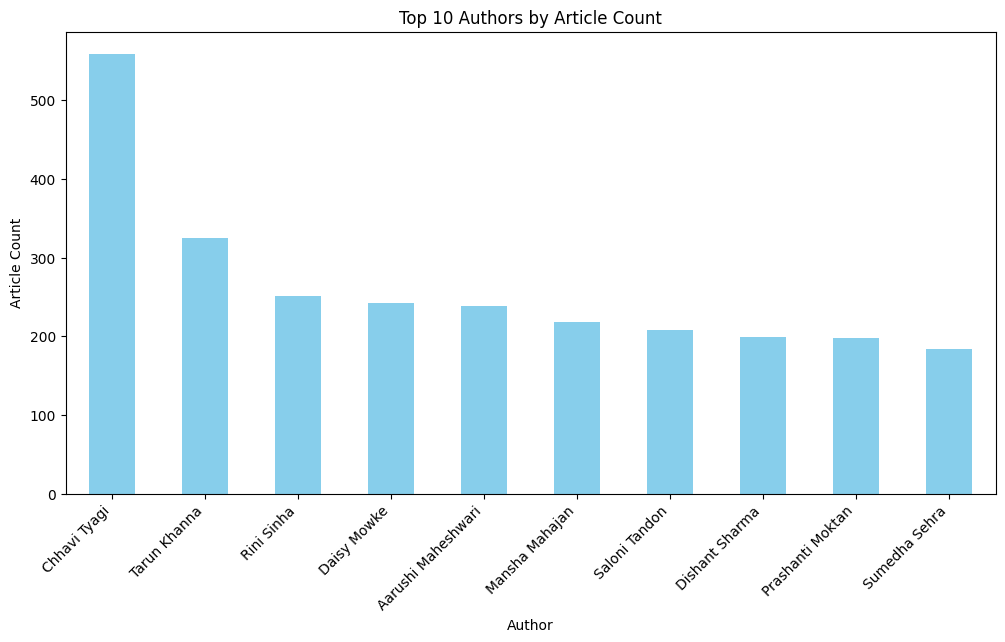

In [33]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the dataset
df = pd.read_csv('news_summary.csv', encoding='ISO-8859-1')

# Plotting the bar chart for author distribution
plt.figure(figsize=(12, 6))
df['author'].value_counts().head(10).plot(kind='bar', color='skyblue')
plt.title('Top 10 Authors by Article Count')
plt.xlabel('Author')
plt.ylabel('Article Count')
plt.xticks(rotation=45, ha='right')  # Rotate author names for better visibility
plt.show()


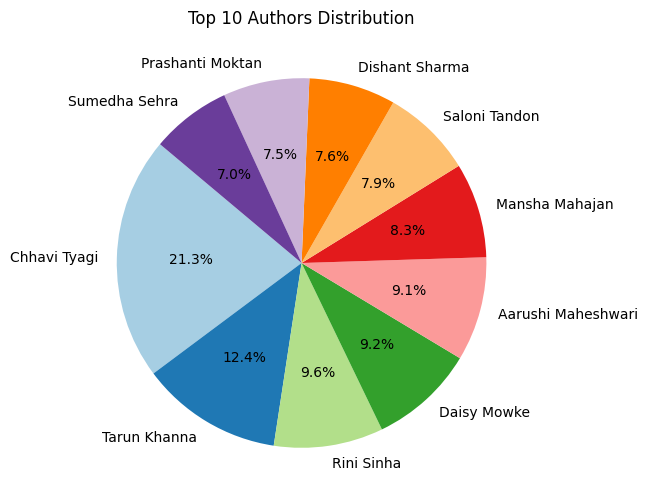

In [35]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the dataset
df = pd.read_csv('news_summary.csv', encoding='ISO-8859-1')

# Plotting the pie chart for author distribution
plt.figure(figsize=(10, 6))
author_counts = df['author'].value_counts()
top_authors = author_counts.head(10)
plt.pie(top_authors, labels=top_authors.index, autopct='%1.1f%%', startangle=140, colors=plt.cm.Paired.colors)
plt.title('Top 10 Authors Distribution')
plt.show()


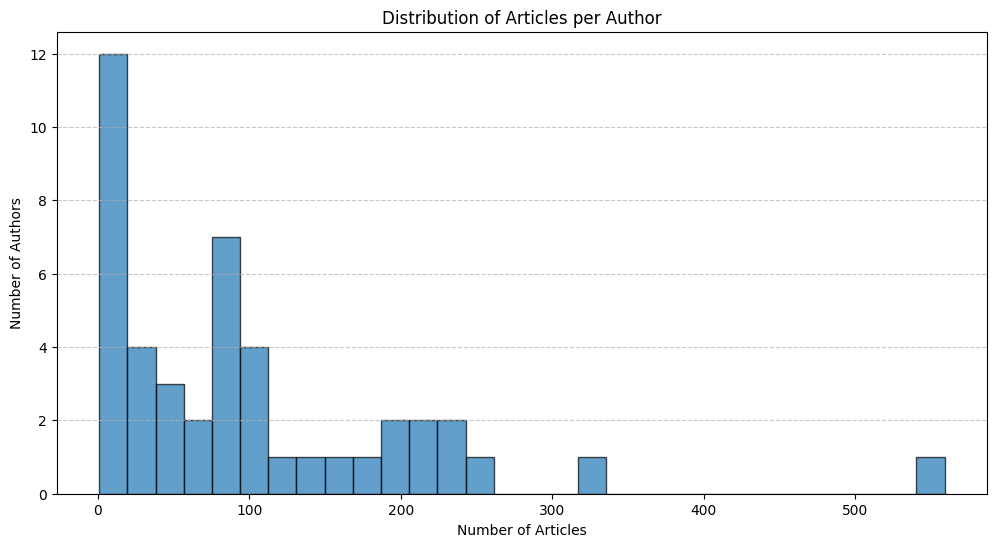

In [40]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the dataset
df = pd.read_csv('news_summary.csv', encoding='ISO-8859-1')

# Plotting the histogram for the distribution of articles per author
plt.figure(figsize=(12, 6))
plt.hist(df['author'].value_counts(), bins=30, edgecolor='black', alpha=0.7)
plt.title('Distribution of Articles per Author')
plt.xlabel('Number of Articles')
plt.ylabel('Number of Authors')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

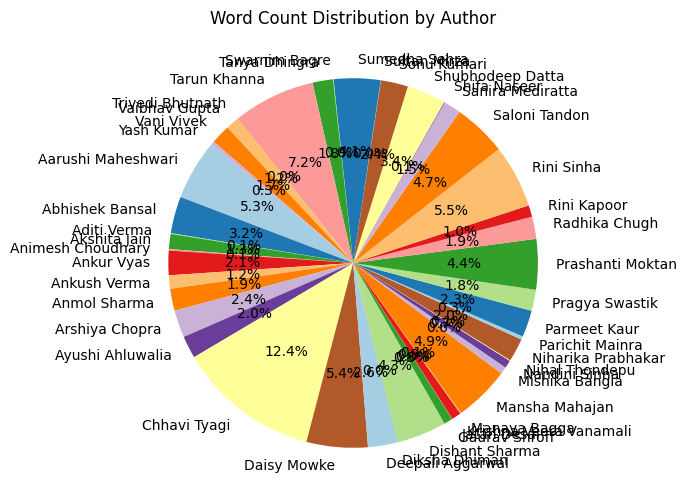

In [43]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the dataset
df = pd.read_csv('news_summary.csv', encoding='ISO-8859-1')

# Assuming you have a 'author' column, adjust it based on your actual column name
author_word_count = df.groupby('author')['text'].apply(lambda x: x.str.split().str.len().sum()).reset_index(name='word_count')

# Plotting the pie chart
plt.figure(figsize=(10, 6))
plt.pie(author_word_count['word_count'], labels=author_word_count['author'], autopct='%1.1f%%', startangle=140, colors=plt.cm.Paired.colors)
plt.title('Word Count Distribution by Author')
plt.show()


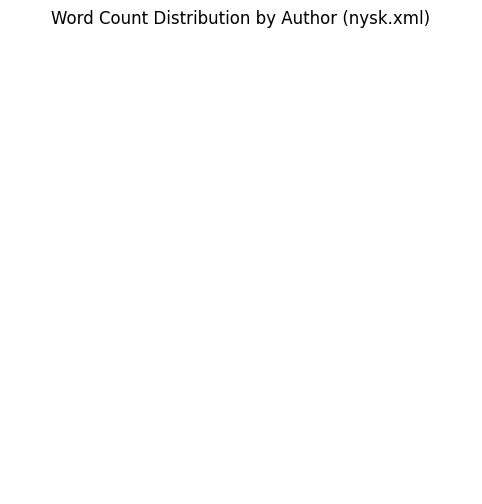

In [46]:
import xml.etree.ElementTree as ET
import pandas as pd
import matplotlib.pyplot as plt

# Parse the XML file
tree = ET.parse('nysk.xml')
root = tree.getroot()

# Create an empty DataFrame to store the data
data = {'author': [], 'word_count': []}

# Iterate through each document in the XML
for document in root.findall('.//document'):
    author_element = document.find('author')
    text_element = document.find('text')

    # Check if the expected elements are present
    if author_element is not None and text_element is not None:
        author = author_element.text
        text = text_element.text

        # Calculate the word count for each document
        word_count = len(text.split())

        # Append data to the DataFrame
        data['author'].append(author)
        data['word_count'].append(word_count)

# Create a DataFrame from the collected data
df = pd.DataFrame(data)

# Calculate the total word count for each author
author_word_count = df.groupby('author')['word_count'].sum().reset_index(name='total_word_count')

# Plotting the pie chart
plt.figure(figsize=(10, 6))
plt.pie(author_word_count['total_word_count'], labels=author_word_count['author'], autopct='%1.1f%%', startangle=140, colors=plt.cm.Paired.colors)
plt.title('Word Count Distribution by Author (nysk.xml)')
plt.show()
